In [20]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import nrrd
from scipy.spatial.distance import directed_hausdorff

import pyvista as pv
pv.set_plot_theme("document")
pv.start_xvfb()

### for enabling latex with pyvista
import vtk
vtk_mathtext = vtk.vtkMathTextFreeTypeTextRenderer()
vtk_mathtext.MathTextIsSupported()

True

In [21]:
# image, _ = nrrd.read("../data/ASOCA/Normal/CTCA/Normal_17.nrrd")
image, _ = nrrd.read("../data/ASOCA/Diseased/CTCA/Diseased_17.nrrd")

# truth_path = "../data_flat/Annotation_Normal_17.nrrd"
truth_path = "../data_flat/Annotation_Diseased_17.nrrd"
nrrd_data, nrrd_header = nrrd.read(truth_path)
lbl = np.array(nrrd_data)

# prediction_path = "../../project/model1_auto3dseg/segresnet_0/prediction_testing/CTCA_Normal_17.nii.gz"
# prediction_path = "model/segresnet_0/prediction_testing/CTCA_Normal_17.nii.gz"
# prediction_path = "model/dints_0/prediction_testing/CTCA_Normal_17/CTCA_Normal_17.nii.gz"
# prediction_path = "/Users/felixrong/Code/TDT4265_StarterCode_2024/final_final/dints/prediction_testing/CTCA_Normal_17/CTCA_Normal_17.nii.gz"
# prediction_path = "/Users/felixrong/Code/TDT4265_StarterCode_2024/final_final/dints/prediction_testing/CTCA_Diseased_20/CTCA_Diseased_20.nii.gz"
prediction_path = "/Users/felixrong/Code/TDT4265_StarterCode_2024/final_final/with_pretrain/ASOCA/segresnet/prediction_testing/CTCA_Diseased_17.nii.gz"
# prediction_path = "/Users/felixrong/Code/TDT4265_StarterCode_2024/final_final/segresnet/prediction_testing/CTCA_Normal_17.nii.gz"
prediction_nib = nib.load(prediction_path)
pred = np.array(prediction_nib.dataobj)

im_shape = pred.shape

In [22]:
# image = nib.load("/Users/felixrong/Code/TDT4265_StarterCode_2024/data_flat_ImageCAS/12085688_img.nii")
# image = np.array(image.dataobj)

# lbl = nib.load("/Users/felixrong/Code/TDT4265_StarterCode_2024/data_flat_ImageCAS/12085688_label.nii")
# lbl = np.array(lbl.dataobj)

# prediction_nib = nib.load("/Users/felixrong/Code/TDT4265_StarterCode_2024/final_final/with_pretrain/ImageCAS/dints/prediction_testing/12085688_img/12085688_img.nii.gz")
# pred = np.array(prediction_nib.dataobj)

# im_shape = pred.shape

109

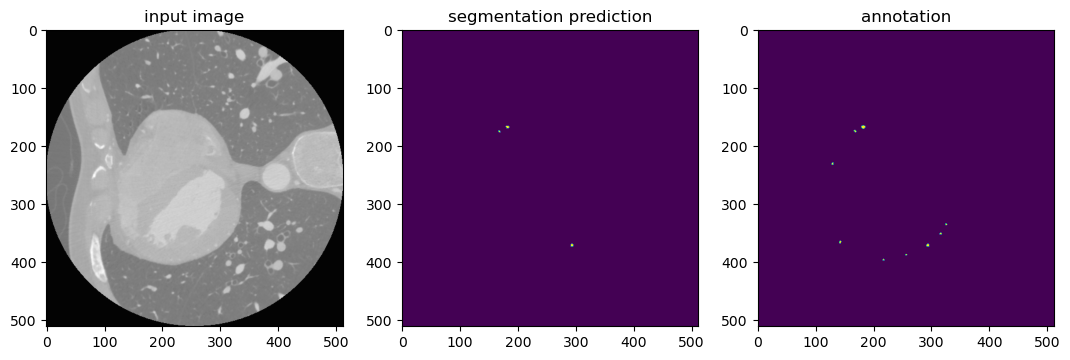

In [23]:
i = np.random.randint(image.shape[2]-1)

fig, axs = plt.subplots(1, 3, figsize=(13, 4))

axs[0].set_title("input image")
axs[0].imshow(image[:, :, i], cmap="gray")
arr = lbl[:,:,i].astype(float)
arr[arr == 0] = np.nan
axs[0].imshow(arr, cmap="bwr_r")

axs[1].set_title("segmentation prediction")
axs[1].imshow(pred[:,:,i], cmap="viridis")

axs[2].set_title("annotation")
axs[2].imshow(lbl[:,:,i], cmap="viridis")

i

In [24]:
# Create a 3D mesh
mesh = pv.wrap(lbl)

# take only the detected aortas (value = 1)
contour = mesh.contour([1], "values")

# contour = mesh.extract_points(mesh["values"] == 1)

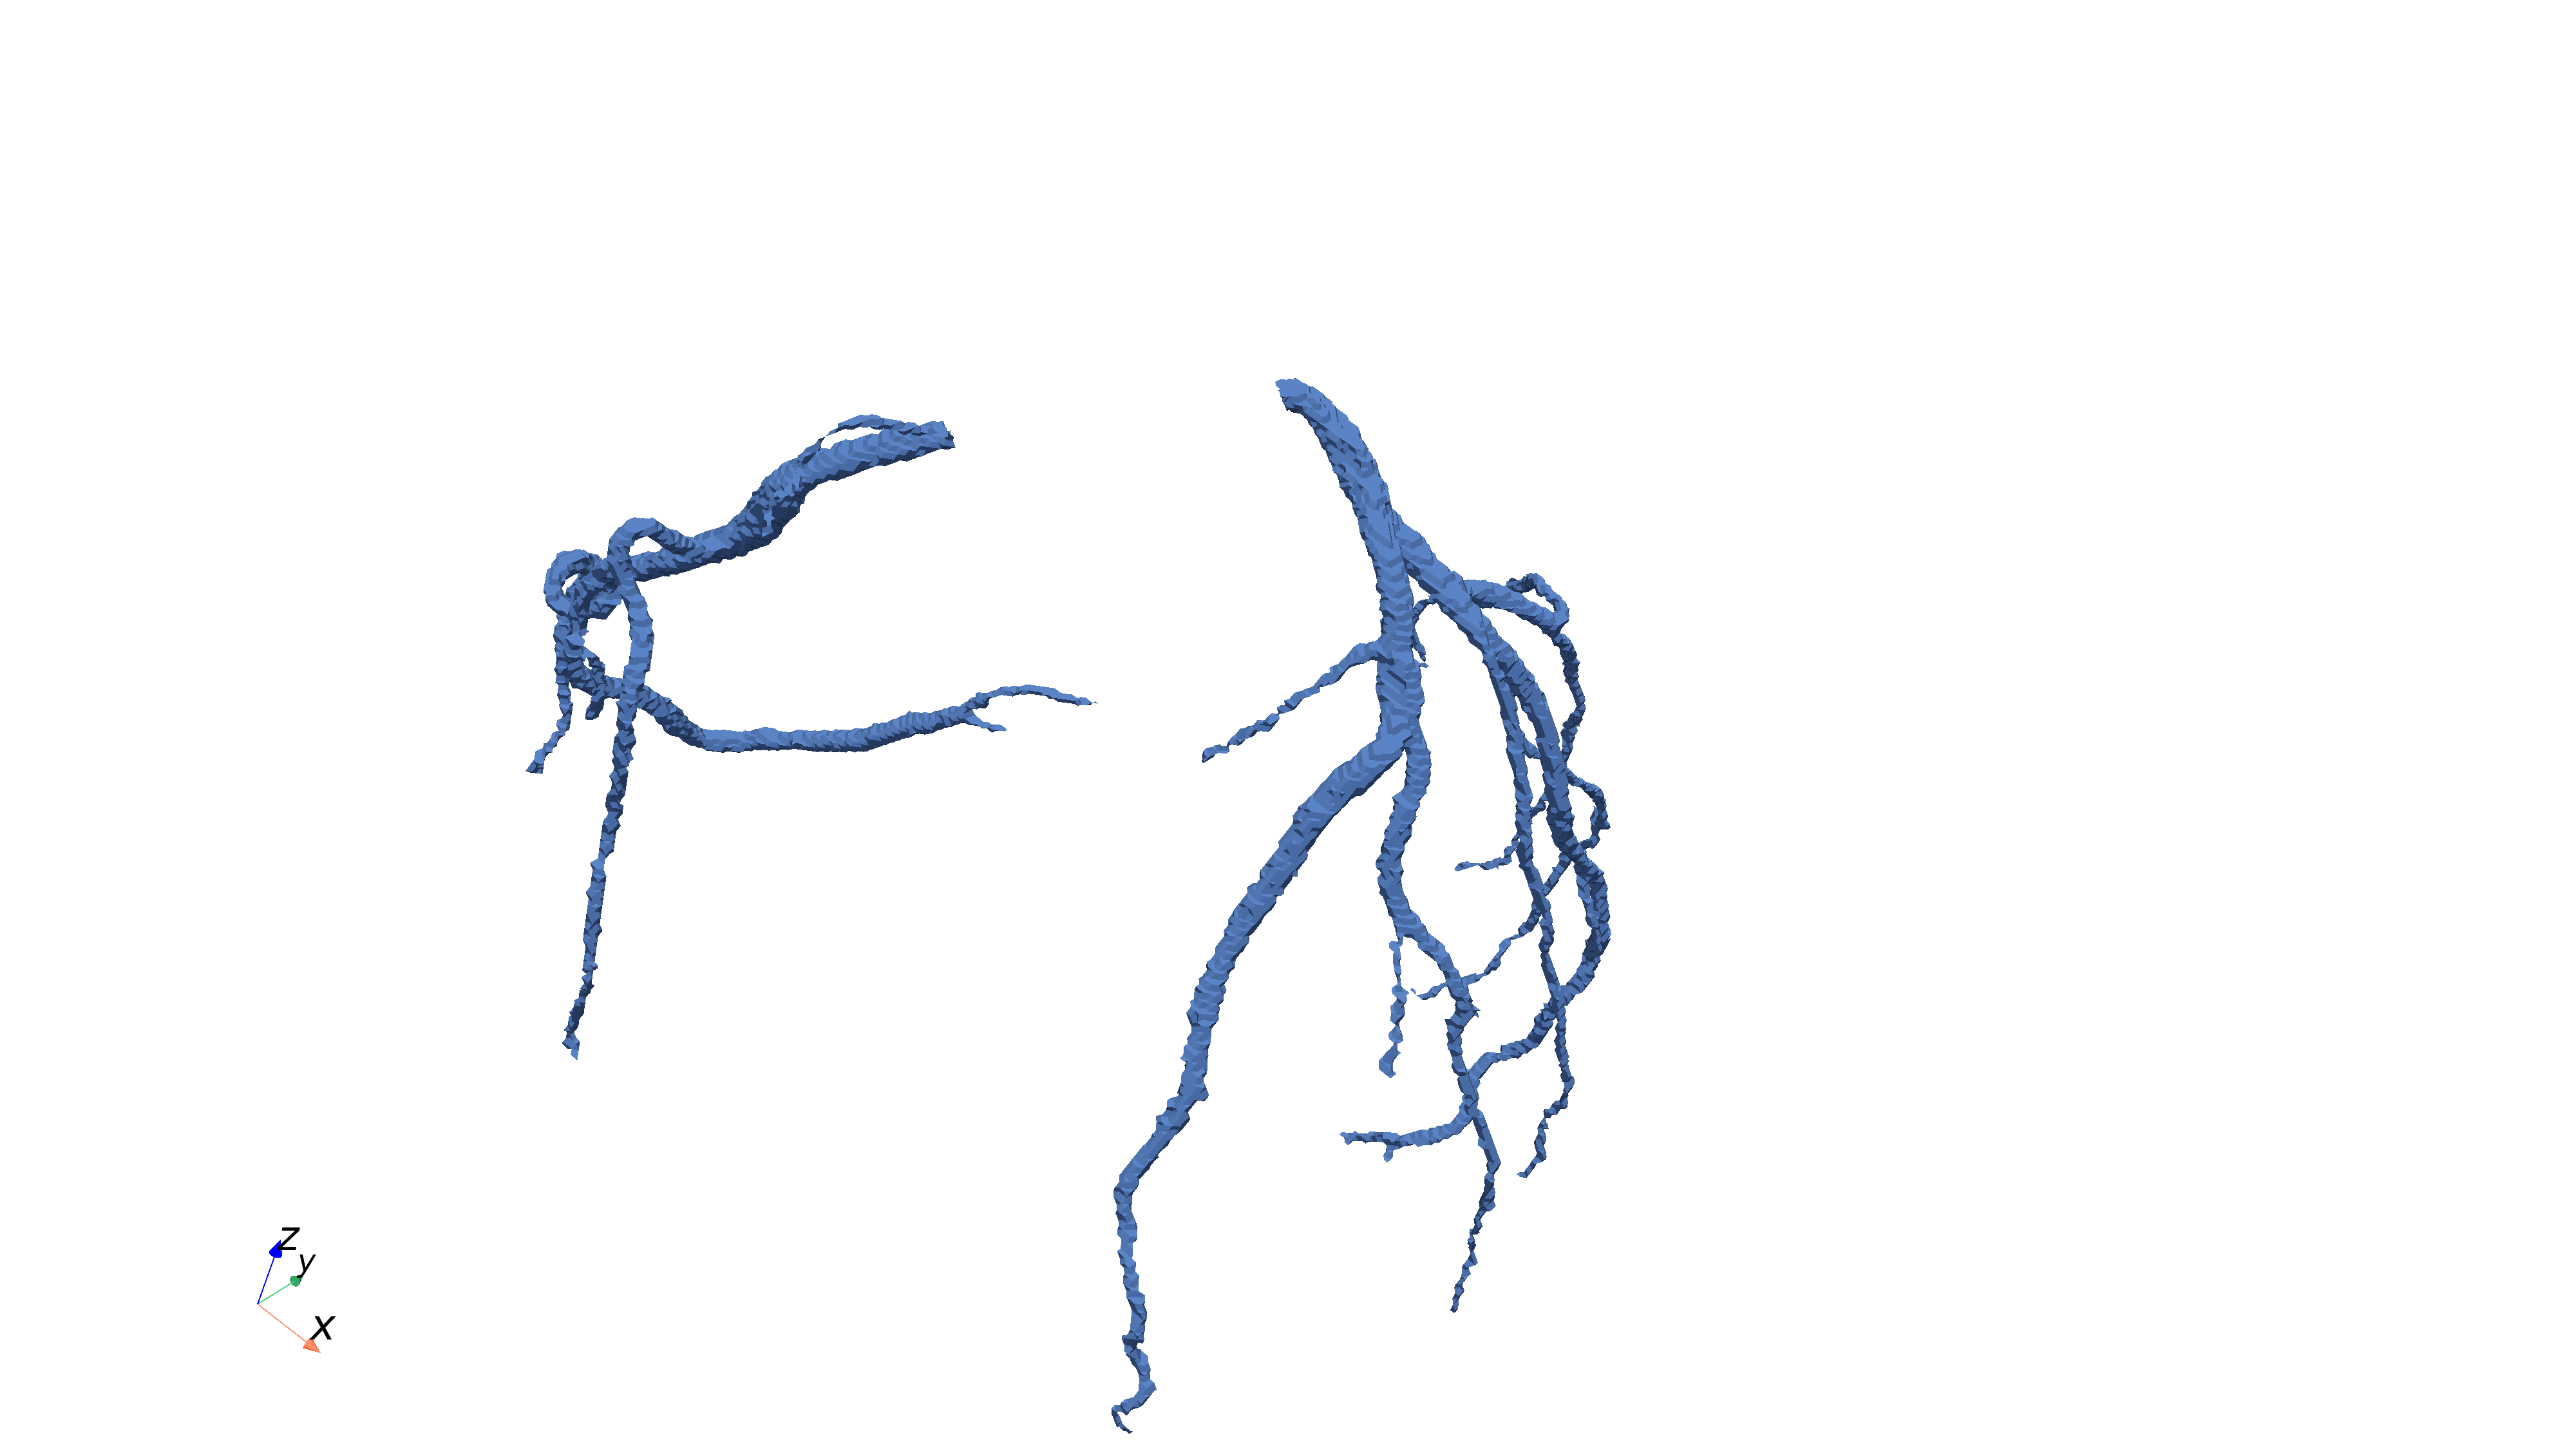

In [25]:
res = 4000 #2000
plotter = pv.Plotter(window_size=(res, int(9 / 16 * res)))

plotter.add_mesh(contour, color="cornflowerblue", opacity=1)#, clim=[min_field_2, max_field_2])
plotter.add_axes(xlabel='$x$', ylabel='$y$', zlabel='$z$')
# plotter.add_bounding_box(line_width=0.01)
# plotter.add_text("Annotation", position=(int(res*0.075), int(res*0.475)), font_size=int(0.0175 * res))

plotter.camera_position = 'xy'

plotter.camera_position = [(503.6302678578769, -140.82967407164097, 511.65039149583697),
 (290.5, 274.0, 120.0),
 (-0.5748435966146002, 0.3858942984487696, 0.7215541766602998)]

# plotter.show(interactive=True)
plotter.show(jupyter_backend='static')

# plotter.screenshot("../Investigations/00005_figures/tec_vortex.jpg")

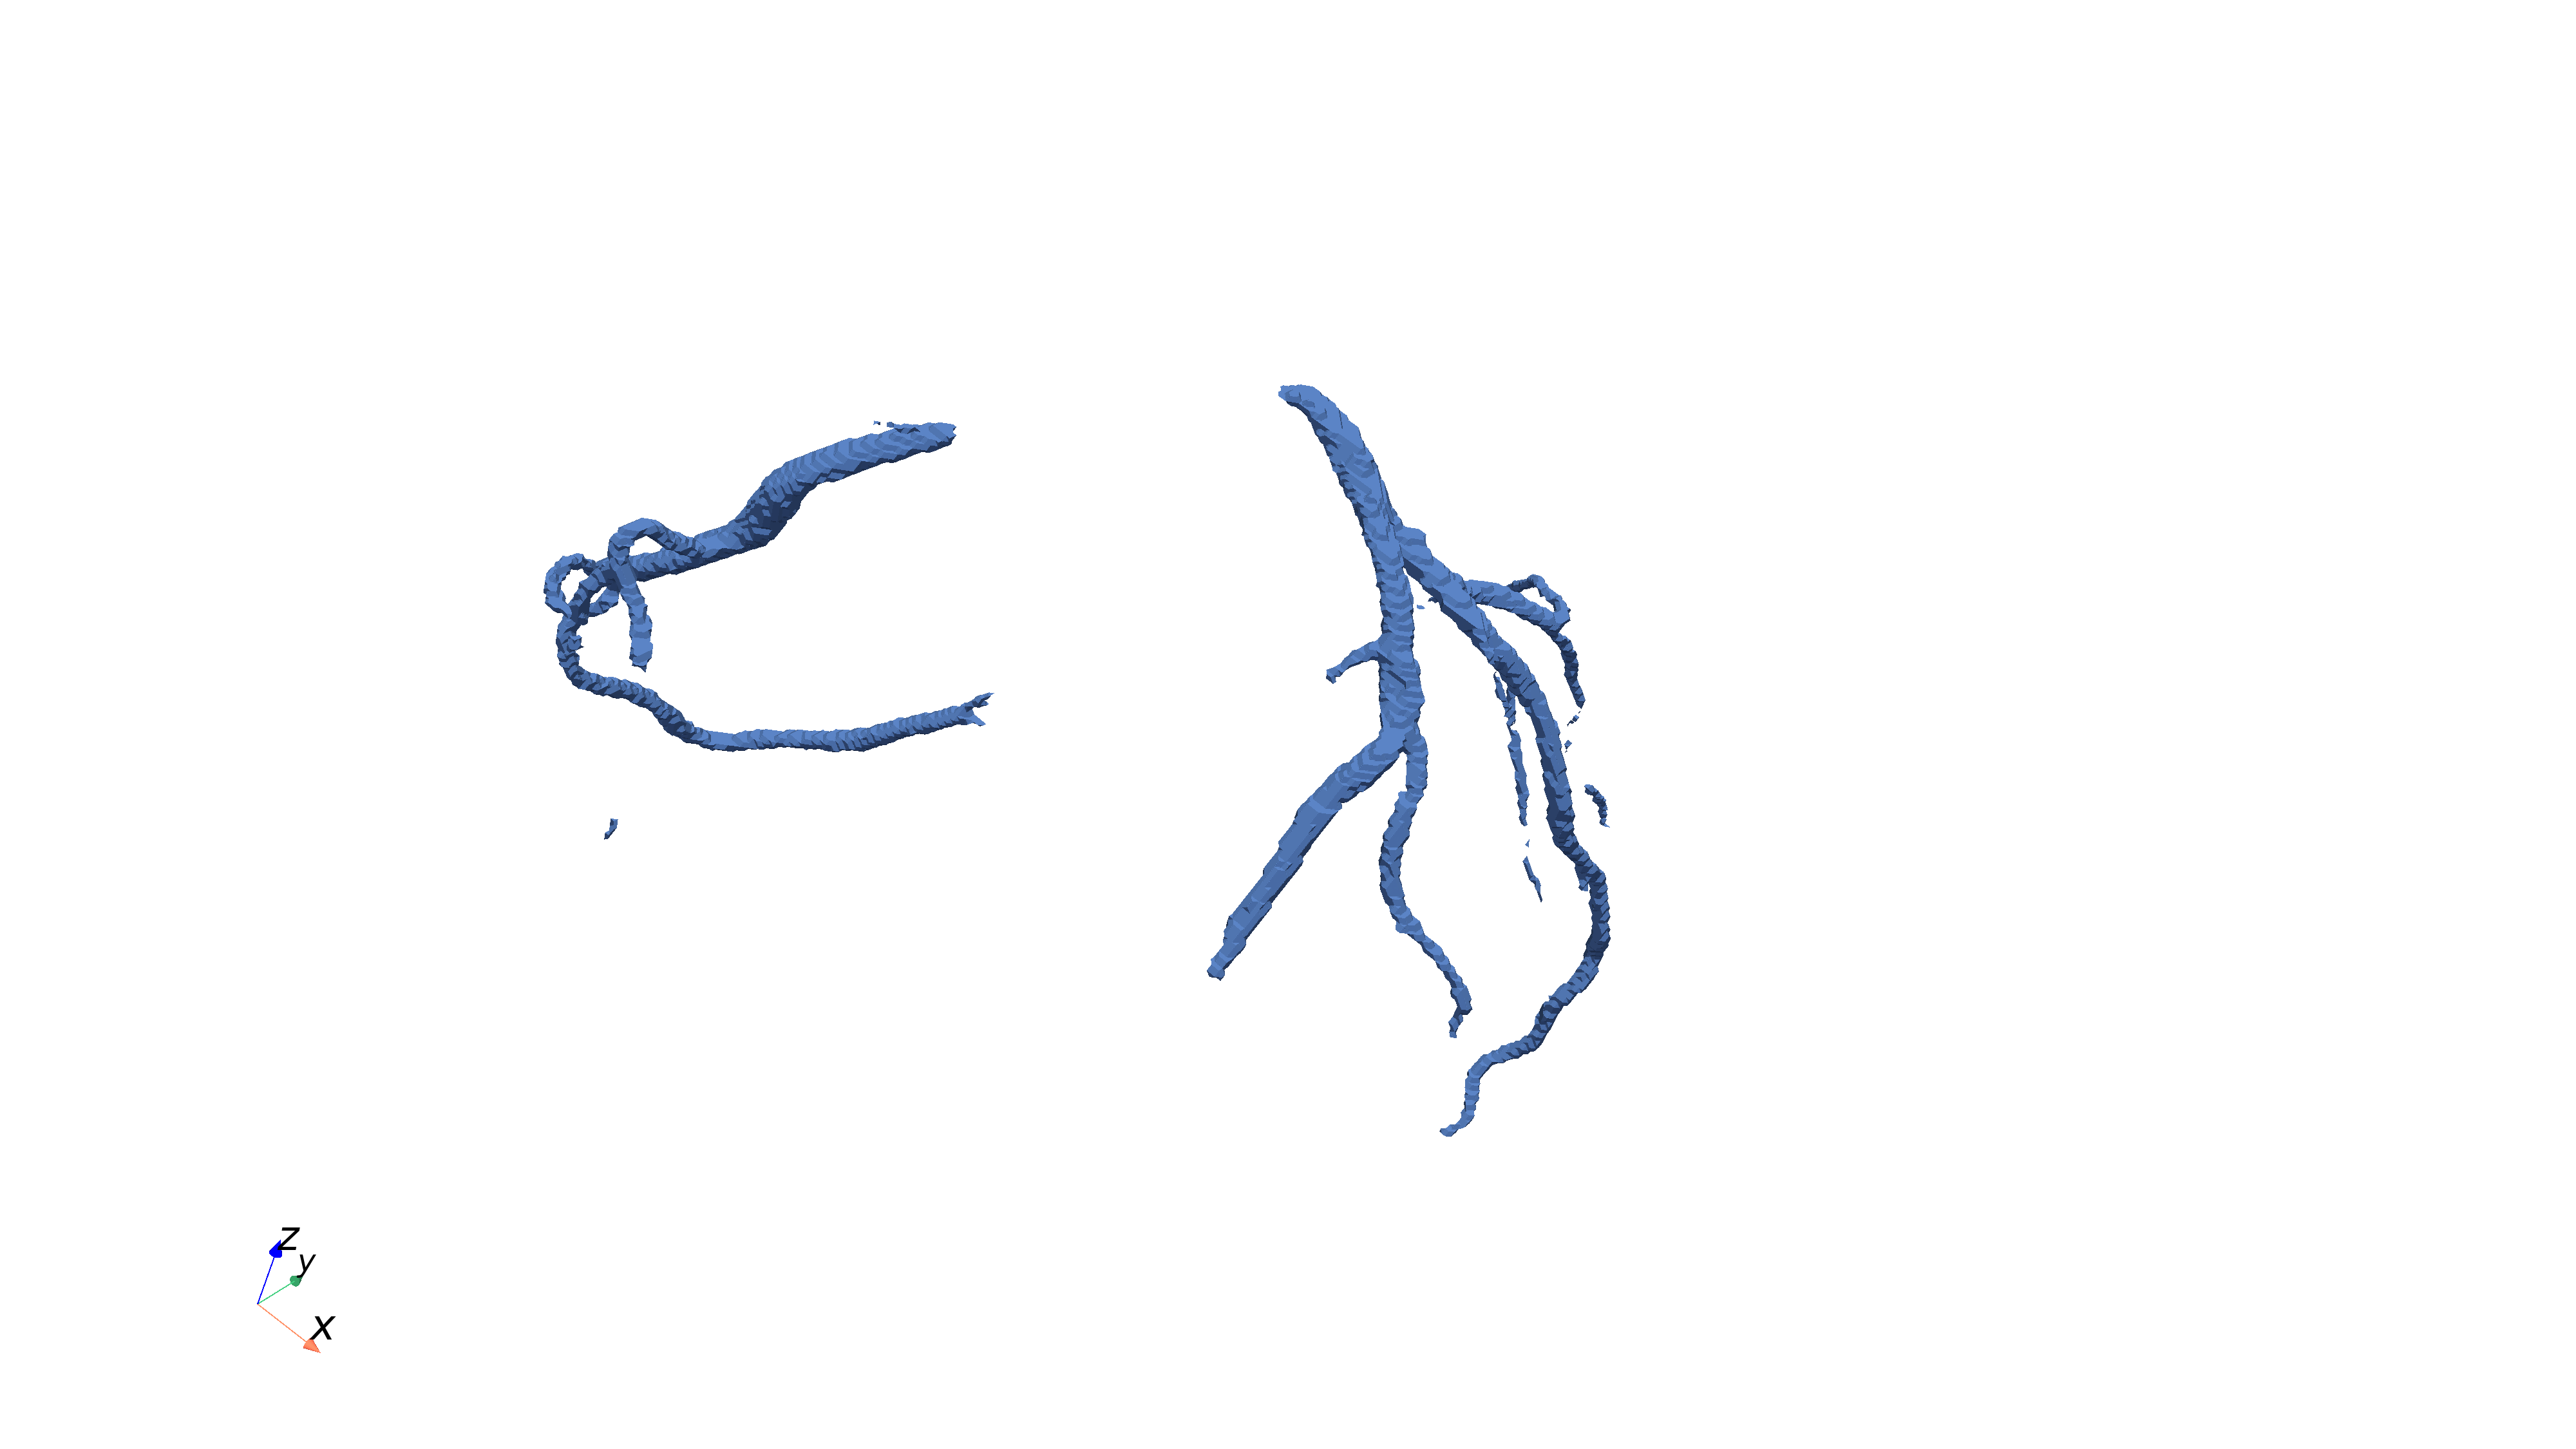

In [26]:
# Create a 3D mesh
mesh_2 = pv.wrap(pred)

# take only the detected aortas (value = 1)
contour_2 = mesh_2.contour([1], "values")
# contour_2 = mesh_2.extract_points(mesh_2["values"] == 1)


res = 4000 #2000
plotter = pv.Plotter(window_size=(res, int(9 / 16 * res)))

plotter.add_mesh(contour_2, color="cornflowerblue", opacity=1)#, clim=[min_field_2, max_field_2])
plotter.add_axes(xlabel='$x$', ylabel='$y$', zlabel='$z$')
# plotter.add_bounding_box(line_width=0.01)
# plotter.add_text("Prediction", position=(int(res*0.075), int(res*0.475)), font_size=int(0.0175 * res))

plotter.camera_position = 'xy'

plotter.camera_position = [(503.6302678578769, -140.82967407164097, 511.65039149583697),
 (290.5, 274.0, 120.0),
 (-0.5748435966146002, 0.3858942984487696, 0.7215541766602998)]

# plotter.show(interactive=True)
plotter.show(jupyter_backend='static')

# plotter.screenshot("../Investigations/00005_figures/tec_vortex.jpg")

In [27]:
## with postprocessing
from skimage import measure

def postproc(pred, threshold = 400):
    # Connected Component Analysis
    labeled_mask, num_components = measure.label(pred, connectivity=1, return_num=True)

    # Filtering Small Components
    for component_label in range(1, num_components + 1):
        component_size = np.sum(labeled_mask == component_label)
        if component_size < threshold:
            labeled_mask[labeled_mask == component_label] = 0

    labeled_mask[labeled_mask>0] = 1        ## set values to 0 and 1
    return labeled_mask

pred_postproc = postproc(pred, threshold = 100)
# pred_postproc[pred_postproc>0] = 1        ## set values to 0 and 1

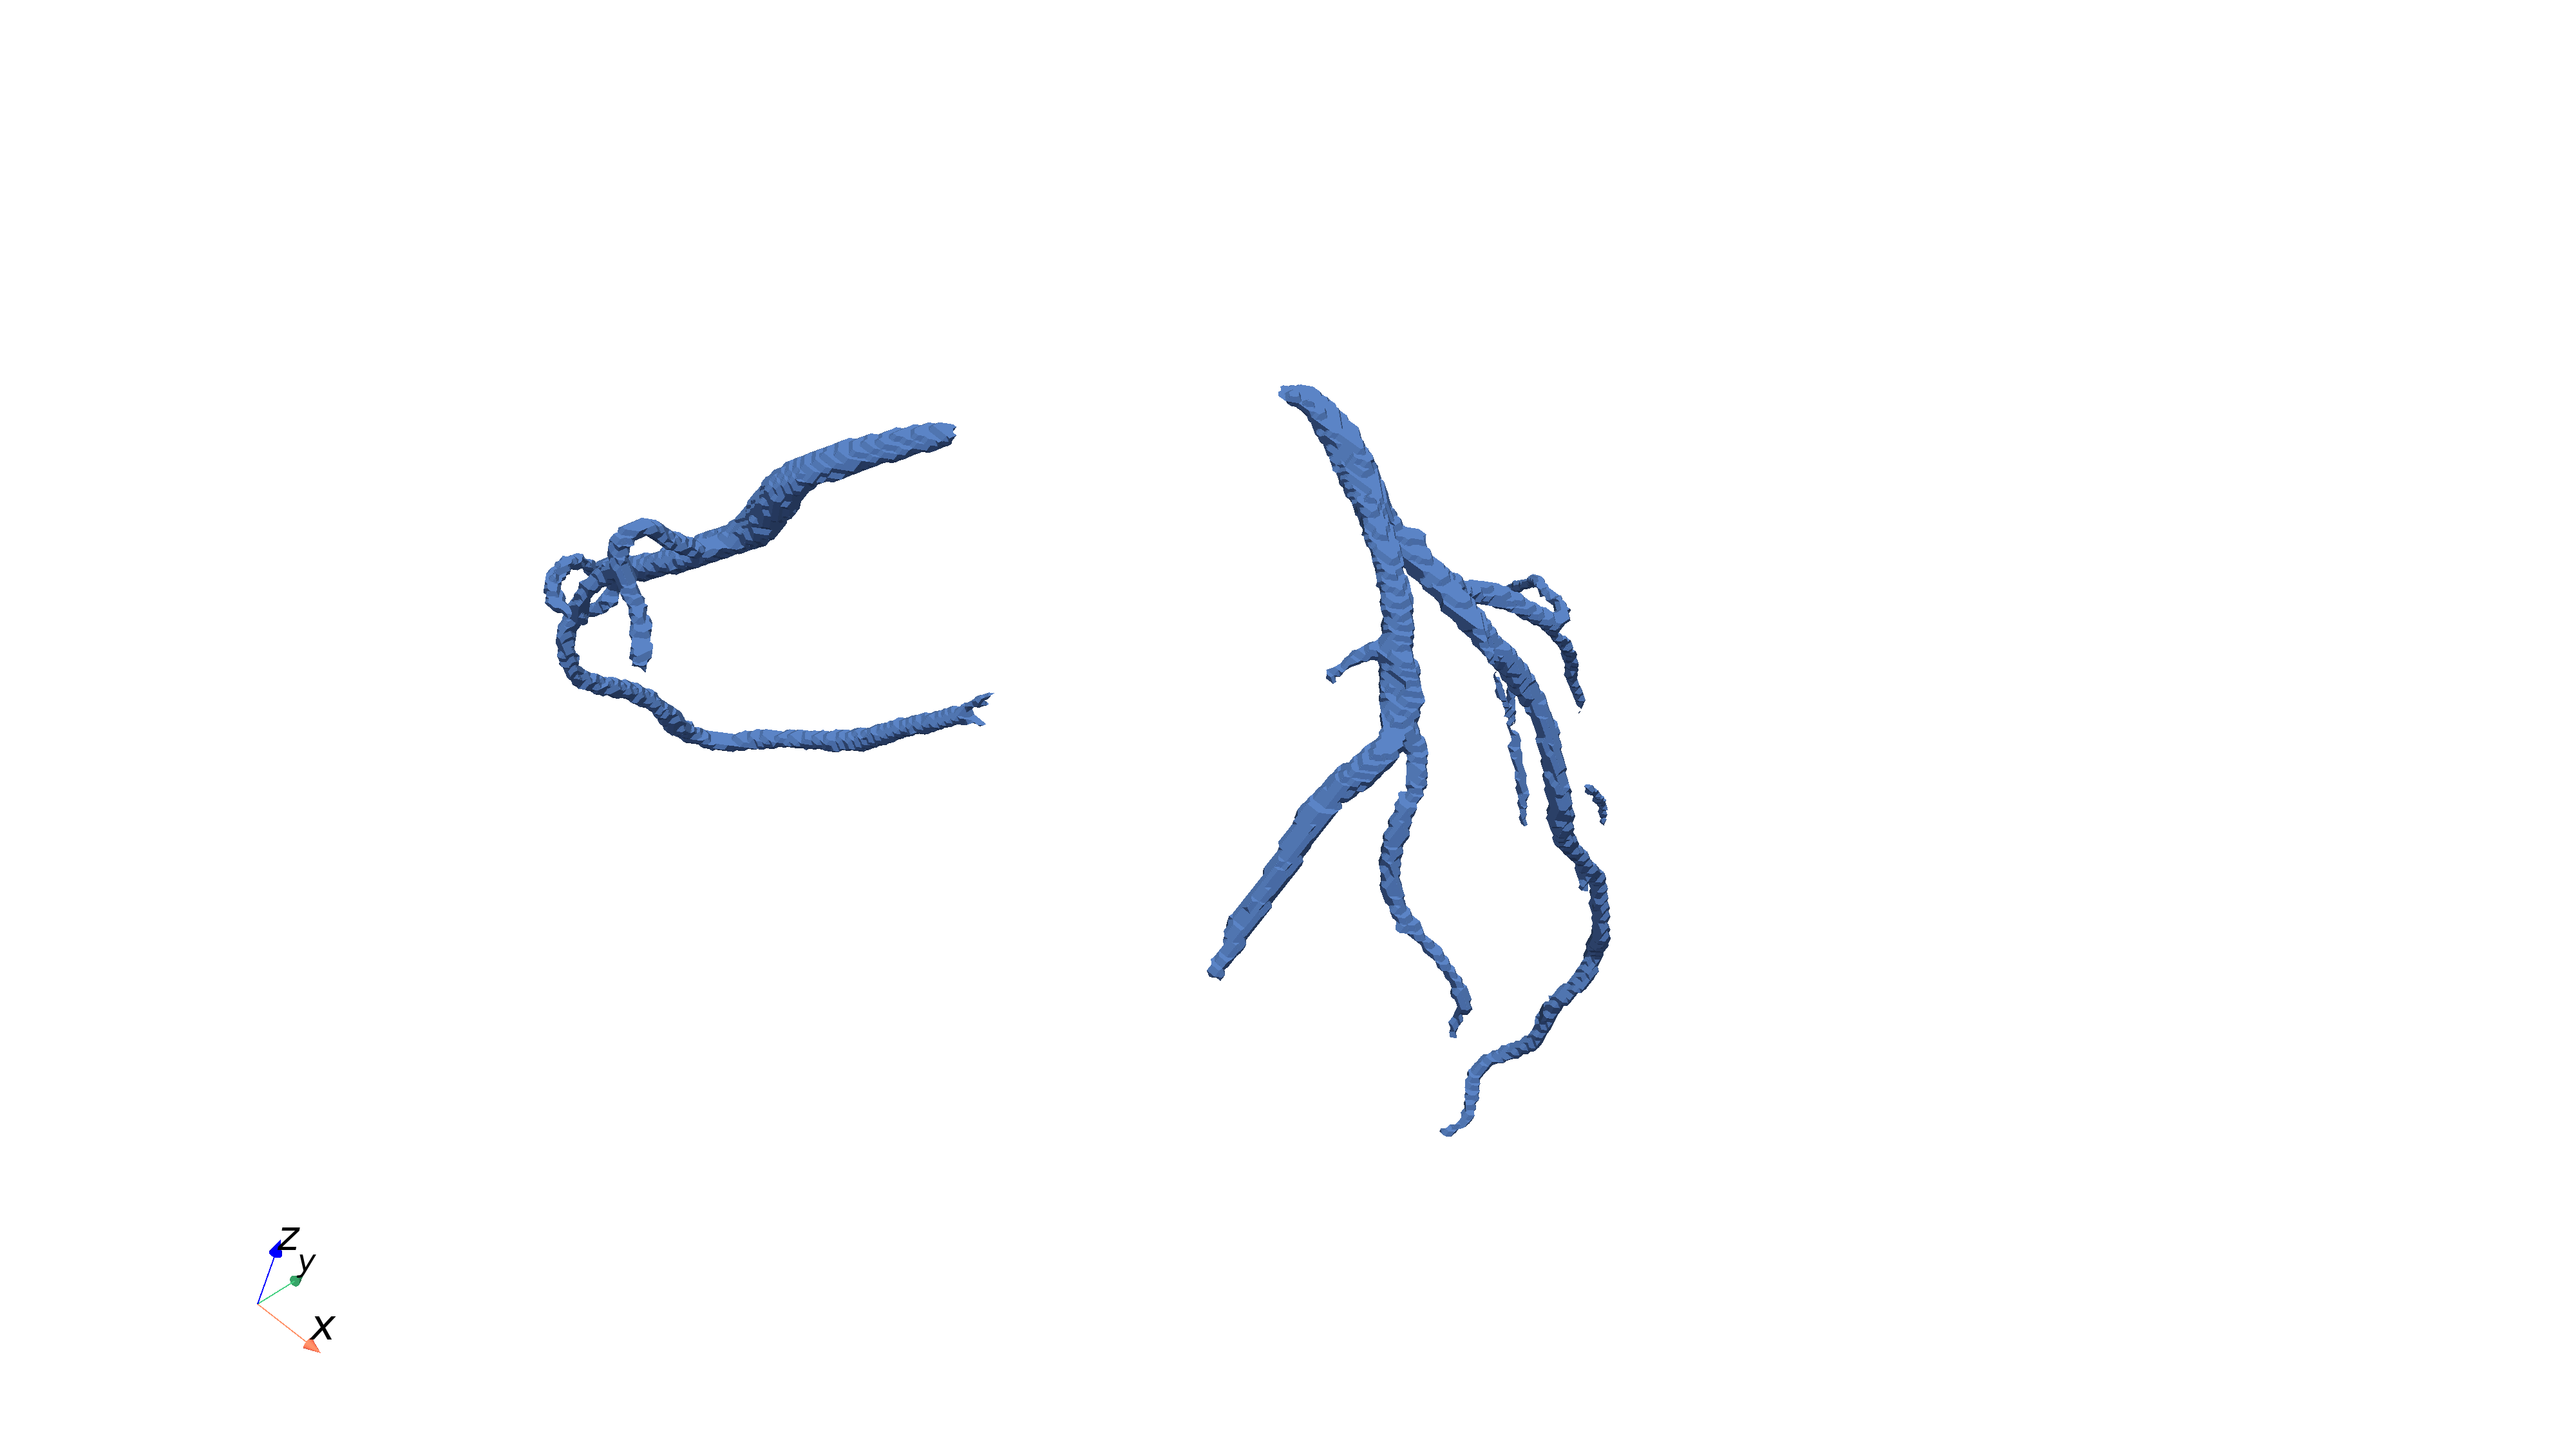

In [28]:
# Create a 3D mesh
mesh_3 = pv.wrap(pred_postproc)

# take only the detected aortas (value = 1)
contour_3 = mesh_3.contour([1], "values")

res = 4000
plotter = pv.Plotter(window_size=(res, int(9 / 16 * res)))

plotter.add_mesh(contour_3, color="cornflowerblue", opacity=1)#, clim=[min_field_2, max_field_2])
plotter.add_axes(xlabel='$x$', ylabel='$y$', zlabel='$z$')
# plotter.add_bounding_box(line_width=0.01)
# plotter.add_text("Prediction + Postproc", position=(int(res*0.075), int(res*0.475)), font_size=int(0.0175 * res))

plotter.camera_position = 'xy'

plotter.camera_position = [(503.6302678578769, -140.82967407164097, 511.65039149583697),
 (290.5, 274.0, 120.0),
 (-0.5748435966146002, 0.3858942984487696, 0.7215541766602998)]

# plotter.show(interactive=True)
plotter.show(jupyter_backend='static')

# plotter.screenshot("../Investigations/00005_figures/tec_vortex.jpg")

In [29]:
## evaluate man HD95 (hausdorff distance) and dice score

def dice_coefficient(prediction, labels):
    # measures the overlap between the predicted segmentation and the ground truth
    intersection = np.sum(prediction * labels)
    union = np.sum(prediction) + np.sum(labels)
    dice = (2.0 * intersection) / (union + 1e-6)
    return dice


def hausdorff_metric(prediction, labels):
    # quantifies the maximum discrepancy between the predicted segmentation and the ground truth
    distances = []
    for i in range(prediction.shape[2]):
        d1 = directed_hausdorff(prediction[:, :, i], labels[:, :, i])[0]
        d2 = directed_hausdorff(labels[:, :, i], prediction[:, :, i])[0]
        distances.extend([d1, d2])
    distances.sort()
    percentile_95 = distances[int(0.95 * len(distances))]
    return percentile_95


# without postproc
mean_dice1 = np.mean([dice_coefficient(pred[:, :, i], lbl[:, :, i]) for i in range(pred.shape[2])])
hausdorff_95_1 = hausdorff_metric(pred, lbl)

# with postproc: makes it a bit better!!!
mean_dice2 = np.mean([dice_coefficient(pred_postproc[:, :, i], lbl[:, :, i]) for i in range(pred.shape[2])])
hausdorff_95_2 = hausdorff_metric(pred, lbl)

In [30]:
((mean_dice2 / mean_dice1) - 1)*100

-1.0854208058322046

In [31]:
((hausdorff_95_2 / hausdorff_95_1) - 1)*100

0.0